# Workshop 11 - Network architectures (ResNET vs CNN)

Code for workshop 11.  This will use Keras (within tensorflow v2)

---
---
## 1. Initialise the environment

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.1.0
2.2.4-tf


---
---
## 2. Load, inspect and prepare the data

We will use MNIST, which is a set of small images (28x28) that contain 10 
digits - see below for class names and an example image.

In [2]:
# This is a built-in data for keras, so easily accessible
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [3]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

(60000, 28, 28)
(10000, 28, 28)


In [4]:
y_train_full

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

float64
float64
7


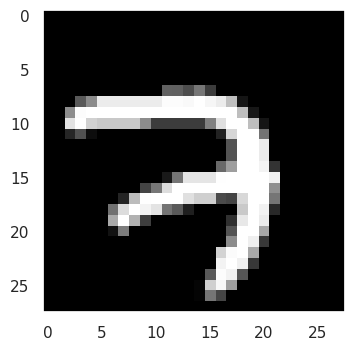

In [5]:
# Scale the data appropriately (it starts with max of 255, but we want
# max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler 
# for this instead. We also split the training set given to us into 
# training and validation subsets 
# The value of 5000 samples as the size of the validation set is an 
# arbitrary choice
X_test = X_test/255.0
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "0","1","2","3","4","5","6","7","8","9" ])

# Inspect some aspects of the data (in general, you should play around 
# with the data more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_valid.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

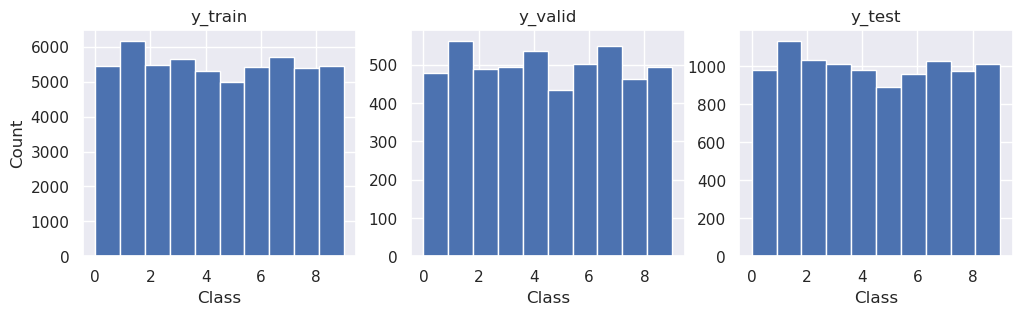

In [6]:
# Let's look at the distribution of labels in the training, validation 
# and test sets
fig, sub = plt.subplots(1, 3)
fig.set_size_inches(12,3)
sub[0].hist(y_train)
sub[0].set_ylabel('Count')
sub[0].set_xlabel('Class')
sub[0].set_title('y_train')
sub[1].hist(y_valid)
sub[1].set_xlabel('Class')
sub[1].set_title('y_valid')
sub[2].hist(y_test)
sub[2].set_xlabel('Class')
sub[2].set_title('y_test')
plt.show()

In [7]:
# Reshape the data to be shape [Nx, Ny, 1]  (previously 2D was fine, but for 
#CNN we need depth too)
X_train = X_train.reshape((-1, 28, 28, 1))
X_valid = X_valid.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

---
---
## 3. Define helper functions that build models in a parameterised way



In [8]:
def model_dense_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))    # always have same sized inputs
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(10, activation = "softmax"))   # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(lr=learningrate), metrics=["accuracy"])
    return model

In [9]:
# Build a CNN
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate=0):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, 
                                  strides=1, activation=actfn, padding="same", 
                                  input_shape=[28, 28, 1]))    
                                  # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))     # Pool (downsize)
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, 
                                      padding="same", activation=actfn))  
                                      # 2nd Conv
        model.add(keras.layers.MaxPooling2D(pool_size=2)) # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, 
                                  strides=1, padding="same", activation=actfn))  
                                  # 2nd Conv
    model.add(keras.layers.Flatten())          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  
        # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer(lr=learningrate), metrics=["accuracy"])   
    return model

# Optional aside: the CNN can become a Fully Convolutional Network (FCN) by 
# replacing the Flatten and Dense lines with model.add(keras.layers.
# Conv2D(filters=10, kernel_size=7, padding="valid", activation="softmax"))
# This uses a kernel equal to the full image size (at this point) to generate 
# a single output per filter which requires the convolution to be "valid" 
# and not "same"

In [10]:
def fit_evaluate(model, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    history = model.fit(X_train[:n_train,:,:,:], y_train[:n_train], epochs=n_epochs, callbacks = [early_stopping_cb] + further_callbacks,
                        validation_data=(X_valid[:n_valid,:,:,:], y_valid[:n_valid]),verbose=1)
    max_val_acc = np.max(history.history['val_accuracy'])
    testres = model.evaluate(X_test, y_test, verbose=0)
    return (max_val_acc, testres[1], history, model)

In [11]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
    plt.show() 

---
---
## 4. Define common modelling parameters



In [12]:
# Some key parameters
n_train = 3000
n_valid = 1000
# Define the number and size of hidden layers
hiddensizes = [16, 32, 16]
# Define the activation function to be used by hidden layers
#actfn = "relu"
actfn = "elu"
# Optimiser and learning rate
#optimizer = keras.optimizers.SGD
#learningrate = 0.01   # SGD default value
optimizer = keras.optimizers.Nadam
learningrate = 0.001   # SGD default value
# Set size of batch and number of epochs
batch_size = 32
n_epochs = 30

In [13]:
# Early stopping callback - this is executed when fitting and will 
# stop and restore best result
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                                  patience=5, 
                                                  restore_best_weights=True) 

---
---
## 5. Build a simple Convolutional Neural Network

We will use the keras version built into tensorflow version 2.
It is remarkably simple for building, training and evaluating networks.

In [14]:
#valacc, testacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model = model_cnn_factory(hiddensizes, actfn, optimizer, learningrate)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 16)          4624      
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 10)                7

In [15]:
# Fit and evaluate the model
valacc, testacc, history, model = fit_evaluate(model, n_train, n_valid, n_epochs, batch_size)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 1s 451us/sample - loss: 0.9976 - accuracy: 0.7057 - val_loss: 0.4233 - val_accuracy: 0.8740
Epoch 2/30
3000/3000 [==============================] - 0s 87us/sample - loss: 0.3136 - accuracy: 0.9000 - val_loss: 0.3081 - val_accuracy: 0.9130
Epoch 3/30
3000/3000 [==============================] - 0s 79us/sample - loss: 0.2170 - accuracy: 0.9363 - val_loss: 0.2441 - val_accuracy: 0.9280
Epoch 4/30
3000/3000 [==============================] - 0s 81us/sample - loss: 0.1648 - accuracy: 0.9523 - val_loss: 0.2317 - val_accuracy: 0.9340
Epoch 5/30
3000/3000 [==============================] - 0s 99us/sample - loss: 0.1246 - accuracy: 0.9610 - val_loss: 0.2351 - val_accuracy: 0.9380
Epoch 6/30
3000/3000 [==============================] - 0s 105us/sample - loss: 0.1029 - accuracy: 0.9667 - val_loss: 0.1792 - val_accuracy: 0.9510
Epoch 7/30
3000/3000 [==============================] - 0s 108us/sam

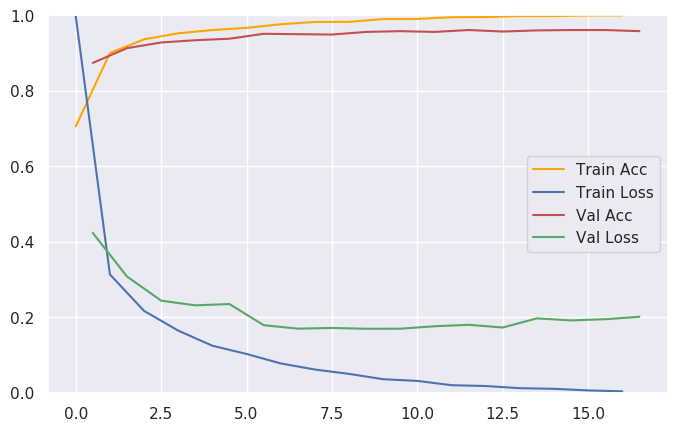

In [16]:
# Inspect the training process
plot_history(history)

In [17]:
# Now run the model on the test set and get results (loss and accuracy 
# both reported)
testres = model.evaluate(X_test, y_test, verbose=0)
print(testres)

[0.15028959266492165, 0.9592]


[7 2 1]
['7' '2' '1']
['7' '2' '1']


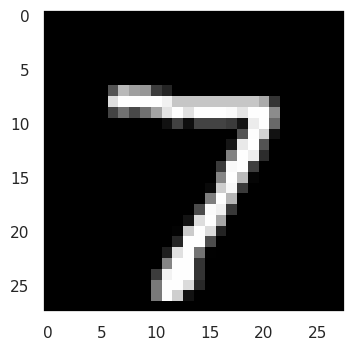

In [18]:
# We can inspect the output class predictions
y_pred = model.predict_classes(X_test[:3])  
    # use the first three test cases as an example
print(y_pred)   # predicted classes
print(class_names[y_pred])   # names of these classes (prediction)
print(class_names[y_test[:3]])   # names of true classes
# Display an image of the first test sample
plt.imshow(X_test[0].reshape((28,28)), cmap="gray")
plt.grid(False)

In [19]:
# We can also look at the probability of predicting each class rather than the class with max probability
# Each row has ten probabilities (one per class)
y_proba = model.predict(X_test[:3])
print(y_proba.round(2))  # round to two decimal places when printing

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


---
---
## 6. Build a small ResNet and run on same data



In [20]:
# Implementation example of Geron: Hands On Machine Learning 2019, Chapter 14
class ResidualUnit (keras.layers.Layer): 
    def __init__ (self, filters, strides=1, activation="relu", **kwargs): 
        super(). __init__ (**kwargs) 
        self.activation = keras.activations.get(activation) 
        self.main_layers = [ 
            keras.layers.Conv2D(filters, 3, strides=strides, 
                                padding="same", use_bias=False), 
            keras.layers.BatchNormalization(), 
            self.activation, 
            keras.layers.Conv2D(filters, 3, strides=1, 
                                padding="same", use_bias=False), 
            keras.layers.BatchNormalization()] 
        self.skip_layers = [] 
        if strides > 1: 
            self.skip_layers = [ 
                keras.layers.Conv2D(filters, 1, strides=strides, 
                                    padding="same", use_bias=False), 
                keras.layers.BatchNormalization()] 
            
    def call(self, inputs): 
        Z = inputs 
        for layer in self.main_layers: 
            Z = layer(Z) 
        skip_Z = inputs 
        for layer in self.skip_layers: 
            skip_Z = layer(skip_Z) 
        return self.activation(Z + skip_Z)


In [21]:
# Build a model manually, because we want to take layers into our own hands 
#(This can be wrapped into a function later for automation.)
initial_filters=32
residual_unit_filters=[32, 53, 128]

model = keras.models.Sequential() 
model.add(keras.layers.Conv2D(initial_filters, 7, strides=2, 
                              input_shape=[28, 28, 1], 
                              padding="same", use_bias=False))
model.add(keras.layers.BatchNormalization()) 
model.add(keras.layers.Activation(actfn)) 
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")) 

prev_filters = initial_filters
for filters in residual_unit_filters: 
    if filters == prev_filters: 
        strides = 1
    else:
        strides = 2
    model.add(ResidualUnit(filters, strides=strides)) 
    prev_filters = filters 
    
model.add(keras.layers.GlobalAvgPool2D()) 
model.add(keras.layers.Flatten()) 
model.add(keras.layers.Dense(10, activation="softmax"))

model.compile(loss="sparse_categorical_crossentropy", 
              optimizer=optimizer(lr=learningrate), 
              metrics=["accuracy"])   

# Output the model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 32)        1568      
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 32)        128       
_________________________________________________________________
activation (Activation)      (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 7, 7, 32)          18688     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 4, 4, 53)          42877     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 2, 2, 128)        

In [22]:
# Fit and evaluate the model
valacc, testacc, history, model = fit_evaluate(model, n_train, n_valid, 
                                               n_epochs, batch_size)

Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 2s 799us/sample - loss: 0.4396 - accuracy: 0.8743 - val_loss: 2.8395 - val_accuracy: 0.1160
Epoch 2/30
3000/3000 [==============================] - 1s 228us/sample - loss: 0.1084 - accuracy: 0.9697 - val_loss: 4.5749 - val_accuracy: 0.1160
Epoch 3/30
3000/3000 [==============================] - 1s 240us/sample - loss: 0.0466 - accuracy: 0.9887 - val_loss: 4.2356 - val_accuracy: 0.1160
Epoch 4/30
3000/3000 [==============================] - 1s 273us/sample - loss: 0.0322 - accuracy: 0.9910 - val_loss: 1.4754 - val_accuracy: 0.5010
Epoch 5/30
3000/3000 [==============================] - 1s 202us/sample - loss: 0.0254 - accuracy: 0.9943 - val_loss: 0.3752 - val_accuracy: 0.8830
Epoch 6/30
3000/3000 [==============================] - 1s 198us/sample - loss: 0.0221 - accuracy: 0.9937 - val_loss: 0.2243 - val_accuracy: 0.9410
Epoch 7/30
3000/3000 [==============================] - 1s 180us

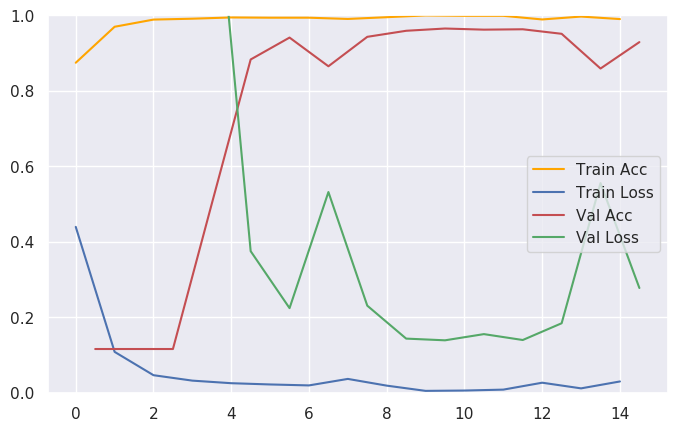

In [23]:
# Inspect the training process
plot_history(history)

In [24]:
# Now run the model on the test set and get results (loss and accuracy both reported)
testres = model.evaluate(X_test, y_test, verbose=0)
print(testres)

[0.09990114254024811, 0.9709]


[7 2 1]
['7' '2' '1']
['7' '2' '1']


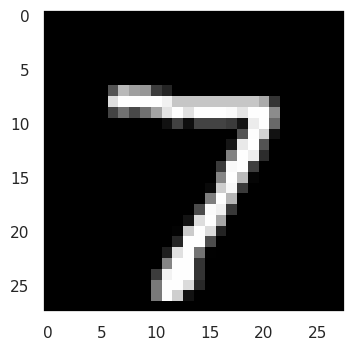

In [25]:
# We can inspect the output class predictions
y_pred = model.predict_classes(X_test[:3])  # use the first three test cases as an example
print(y_pred)   # predicted classes
print(class_names[y_pred])   # names of these classes (prediction)
print(class_names[y_test[:3]])   # names of true classes
# Display an image of the first test sample
plt.imshow(X_test[0].reshape((28,28)), cmap="gray")
plt.grid(False)

In [26]:
# We can also look at the probability of predicting each class rather than the class with max probability
# Each row has ten probabilities (one per class)
y_proba = model.predict(X_test[:3])
print(y_proba.round(2))  # round to two decimal places when printing

[[0.   0.   0.   0.   0.   0.   0.   1.   0.   0.  ]
 [0.   0.   0.99 0.   0.   0.   0.   0.   0.   0.  ]
 [0.   1.   0.   0.   0.   0.   0.   0.   0.   0.  ]]


---
---
## 7. Your Task

- Filter size: change the ResNet architecture to a series of 2 Residual Units with same filter size of 8, then 16, 32, 64, 128. Which one appears best?
- Number of residual units: use 32 filters per RU, change the number of RUs from 1 to 2,3,4,5,6. Which one appears best?

Write your answers and findings below:

Answer:

In [27]:
# Build a model manually, because we want to take layers into our own hands 
#(This can be wrapped into a function later for automation.)
filter_size = [8,16,32,64,128]
acc_result = []
history_result = []
for f_size in filter_size:

    initial_filters=32
    residual_unit_filters=[f_size, f_size]

    model = keras.models.Sequential() 
    model.add(keras.layers.Conv2D(initial_filters, 7, strides=2, 
                                  input_shape=[28, 28, 1], 
                                  padding="same", use_bias=False))
    model.add(keras.layers.BatchNormalization()) 
    model.add(keras.layers.Activation(actfn)) 
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")) 

    prev_filters = initial_filters
    for filters in residual_unit_filters: 
        if filters == prev_filters: 
            strides = 1
        else:
            strides = 2
        model.add(ResidualUnit(filters, strides=strides)) 
        prev_filters = filters 

    model.add(keras.layers.GlobalAvgPool2D()) 
    model.add(keras.layers.Flatten()) 
    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer(lr=learningrate), 
                  metrics=["accuracy"])   

    # Output the model summary
    model.summary()
    valacc, testacc, history, model = fit_evaluate(model, n_train, n_valid, 
                                               n_epochs, batch_size)
    acc_result.append(valacc)
    history_result.append(history)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 14, 14, 32)        1568      
_________________________________________________________________
batch_normalization_9 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
residual_unit_3 (ResidualUni (None, 4, 4, 8)           3232      
_________________________________________________________________
residual_unit_4 (ResidualUni (None, 4, 4, 8)           1216      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 8)                

Epoch 18/30
3000/3000 [==============================] - 1s 241us/sample - loss: 0.0118 - accuracy: 0.9997 - val_loss: 0.1314 - val_accuracy: 0.9640
Epoch 19/30
3000/3000 [==============================] - 1s 231us/sample - loss: 0.0126 - accuracy: 0.9997 - val_loss: 0.1522 - val_accuracy: 0.9570
Epoch 20/30
3000/3000 [==============================] - 1s 224us/sample - loss: 0.0110 - accuracy: 0.9997 - val_loss: 0.2098 - val_accuracy: 0.9390
Epoch 21/30
3000/3000 [==============================] - 1s 230us/sample - loss: 0.0106 - accuracy: 0.9990 - val_loss: 0.1551 - val_accuracy: 0.9570
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 14, 14, 32)        1568      
_________________________________________________________________
batch_normalization_21 (Batc (None, 14, 14, 32)        128       
____________________________________________________

Epoch 17/30
3000/3000 [==============================] - 1s 230us/sample - loss: 0.1160 - accuracy: 0.9653 - val_loss: 0.6891 - val_accuracy: 0.8270
Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_35 (Conv2D)           (None, 14, 14, 32)        1568      
_________________________________________________________________
batch_normalization_32 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
activation_5 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
residual_unit_11 (ResidualUn (None, 4, 4, 128)         189952    
_________________________________________________________________
residual_unit_12 (ResidualUn (None, 4

[0.949, 0.967, 0.953, 0.982, 0.969]


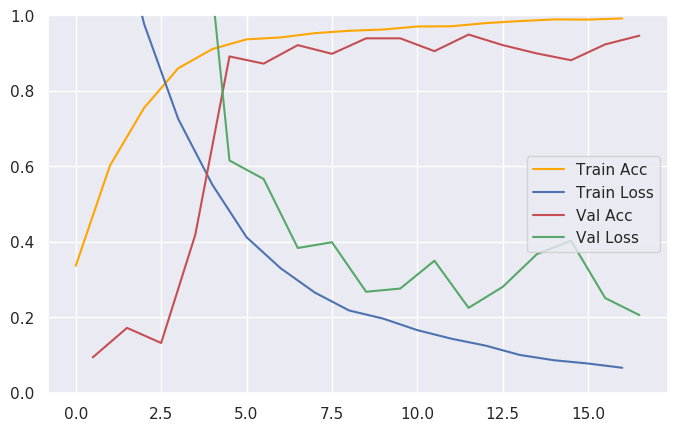

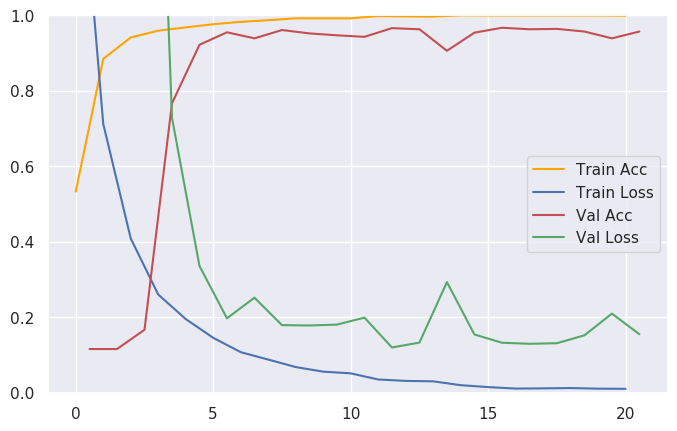

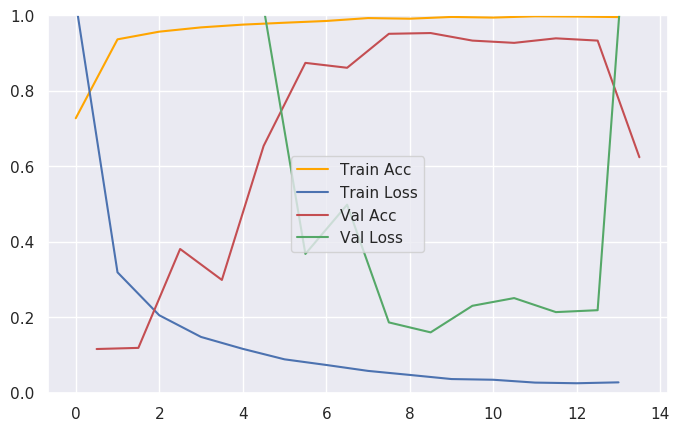

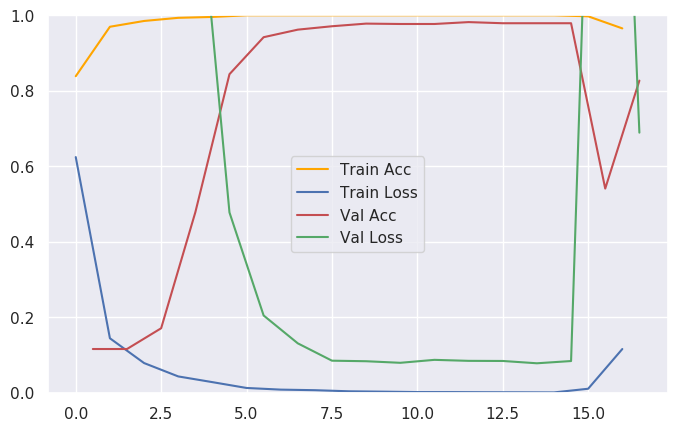

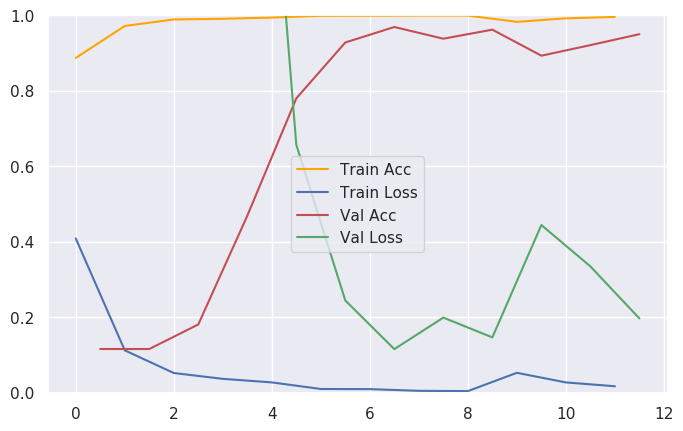

In [28]:
print(acc_result)
for his in history_result:
    
    plot_history(his)

In [29]:
# Build a model manually, because we want to take layers into our own hands 
#(This can be wrapped into a function later for automation.)
filter_size = [32]
acc_result = []
history_result = []
for f_size in filter_size:

    initial_filters=32
    
    
    for i in range(6):
        residual_unit_filters=[]
        for j in range(6):
            if j<i:
                residual_unit_filters.append(f_size)

        model = keras.models.Sequential() 
        model.add(keras.layers.Conv2D(initial_filters, 7, strides=2, 
                                      input_shape=[28, 28, 1], 
                                      padding="same", use_bias=False))
        model.add(keras.layers.BatchNormalization()) 
        model.add(keras.layers.Activation(actfn)) 
        model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")) 

        prev_filters = initial_filters
        for filters in residual_unit_filters: 
            if filters == prev_filters: 
                strides = 1
            else:
                strides = 2
            model.add(ResidualUnit(filters, strides=strides)) 
            prev_filters = filters 

        model.add(keras.layers.GlobalAvgPool2D()) 
        model.add(keras.layers.Flatten()) 
        model.add(keras.layers.Dense(10, activation="softmax"))

        model.compile(loss="sparse_categorical_crossentropy", 
                      optimizer=optimizer(lr=learningrate), 
                      metrics=["accuracy"])   

        # Output the model summary
        model.summary()
        valacc, testacc, history, model = fit_evaluate(model, n_train, n_valid, 
                                                   n_epochs, batch_size)
        acc_result.append(valacc)
        history_result.append(history)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_41 (Conv2D)           (None, 14, 14, 32)        1568      
_________________________________________________________________
batch_normalization_38 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
activation_6 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
global_average_pooling2d_6 ( (None, 32)                0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)               

3000/3000 [==============================] - 1s 183us/sample - loss: 0.0445 - accuracy: 0.9940 - val_loss: 0.6069 - val_accuracy: 0.8200
Epoch 16/30
3000/3000 [==============================] - 1s 180us/sample - loss: 0.0423 - accuracy: 0.9953 - val_loss: 0.3163 - val_accuracy: 0.9040
Epoch 17/30
3000/3000 [==============================] - 0s 110us/sample - loss: 0.0373 - accuracy: 0.9963 - val_loss: 0.1820 - val_accuracy: 0.9490
Epoch 18/30
3000/3000 [==============================] - 0s 98us/sample - loss: 0.0282 - accuracy: 0.9980 - val_loss: 0.3342 - val_accuracy: 0.9020
Epoch 19/30
3000/3000 [==============================] - 0s 102us/sample - loss: 0.0231 - accuracy: 0.9993 - val_loss: 0.2025 - val_accuracy: 0.9480
Epoch 20/30
3000/3000 [==============================] - 0s 104us/sample - loss: 0.0225 - accuracy: 0.9987 - val_loss: 0.1599 - val_accuracy: 0.9470
Epoch 21/30
3000/3000 [==============================] - 0s 103us/sample - loss: 0.0228 - accuracy: 0.9980 - val_loss: 

Epoch 3/30
3000/3000 [==============================] - 1s 251us/sample - loss: 0.1845 - accuracy: 0.9547 - val_loss: 6.2844 - val_accuracy: 0.1160
Epoch 4/30
3000/3000 [==============================] - 1s 182us/sample - loss: 0.1299 - accuracy: 0.9687 - val_loss: 3.9004 - val_accuracy: 0.1620
Epoch 5/30
3000/3000 [==============================] - 1s 255us/sample - loss: 0.0978 - accuracy: 0.9750 - val_loss: 0.5102 - val_accuracy: 0.8240
Epoch 6/30
3000/3000 [==============================] - 1s 173us/sample - loss: 0.0766 - accuracy: 0.9807 - val_loss: 0.5103 - val_accuracy: 0.8340
Epoch 7/30
3000/3000 [==============================] - 1s 229us/sample - loss: 0.0577 - accuracy: 0.9857 - val_loss: 0.4001 - val_accuracy: 0.8750
Epoch 8/30
3000/3000 [==============================] - 1s 192us/sample - loss: 0.0499 - accuracy: 0.9873 - val_loss: 0.2280 - val_accuracy: 0.9230
Epoch 9/30
3000/3000 [==============================] - 1s 178us/sample - loss: 0.0395 - accuracy: 0.9910 - val_

3000/3000 [==============================] - 2s 807us/sample - loss: 0.8432 - accuracy: 0.7687 - val_loss: 7.3196 - val_accuracy: 0.1160
Epoch 2/30
3000/3000 [==============================] - 1s 219us/sample - loss: 0.1894 - accuracy: 0.9493 - val_loss: 12.1635 - val_accuracy: 0.1160
Epoch 3/30
3000/3000 [==============================] - 1s 265us/sample - loss: 0.1191 - accuracy: 0.9660 - val_loss: 8.8533 - val_accuracy: 0.1160
Epoch 4/30
3000/3000 [==============================] - 1s 262us/sample - loss: 0.0937 - accuracy: 0.9723 - val_loss: 1.9865 - val_accuracy: 0.4990
Epoch 5/30
3000/3000 [==============================] - 1s 292us/sample - loss: 0.0632 - accuracy: 0.9823 - val_loss: 0.5322 - val_accuracy: 0.8600
Epoch 6/30
3000/3000 [==============================] - 1s 287us/sample - loss: 0.0483 - accuracy: 0.9880 - val_loss: 0.3858 - val_accuracy: 0.8980
Epoch 7/30
3000/3000 [==============================] - 1s 279us/sample - loss: 0.0383 - accuracy: 0.9907 - val_loss: 0.20

[0.673, 0.961, 0.967, 0.977, 0.957, 0.956]


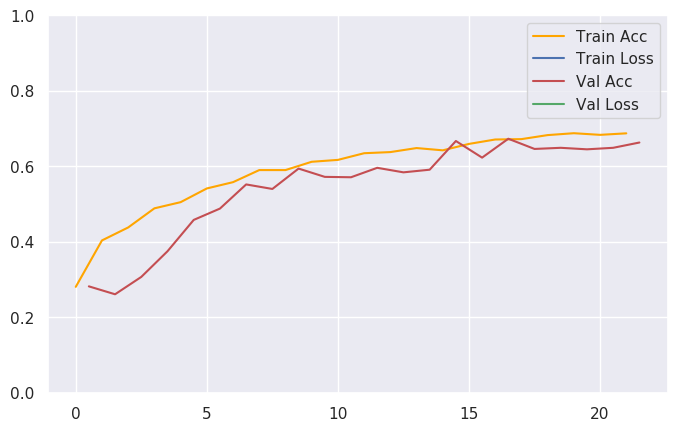

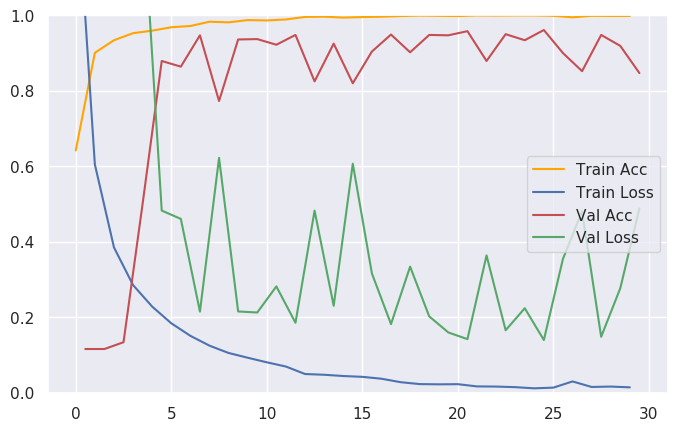

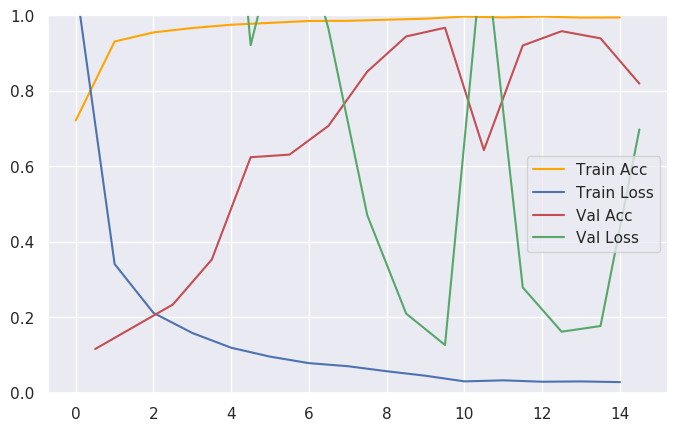

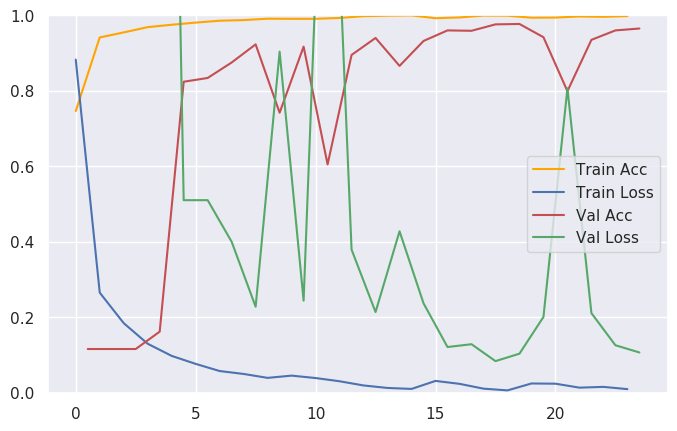

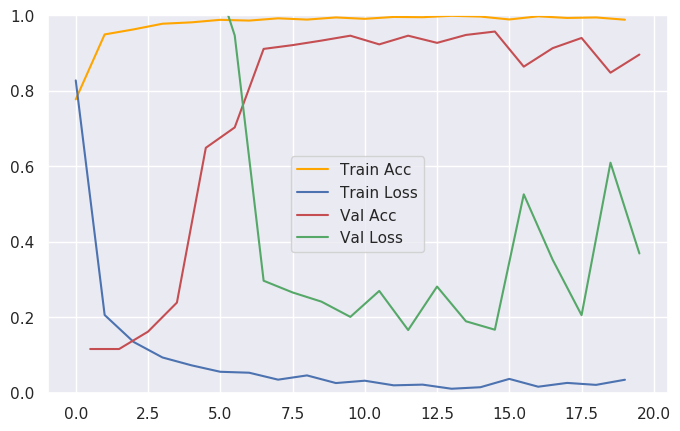

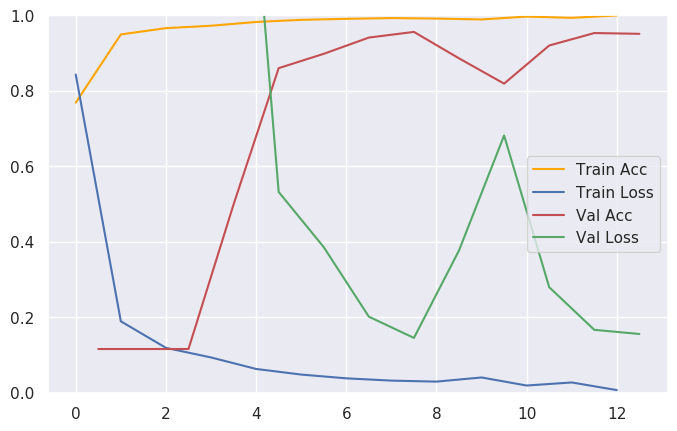

In [30]:
print(acc_result)
for his in history_result:
    
    plot_history(his)

In [31]:
# Build a model manually, because we want to take layers into our own hands 
#(This can be wrapped into a function later for automation.)
filter_size = [8,16,32,64,128]
acc_result = []
history_result = []
for f_size in filter_size:

    initial_filters=32
    residual_unit_filters=[f_size,f_size, f_size]

    model = keras.models.Sequential() 
    model.add(keras.layers.Conv2D(initial_filters, 7, strides=2, 
                                  input_shape=[28, 28, 1], 
                                  padding="same", use_bias=False))
    model.add(keras.layers.BatchNormalization()) 
    model.add(keras.layers.Activation(actfn)) 
    model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="same")) 

    prev_filters = initial_filters
    for filters in residual_unit_filters: 
        if filters == prev_filters: 
            strides = 1
        else:
            strides = 2
        model.add(ResidualUnit(filters, strides=strides)) 
        prev_filters = filters 

    model.add(keras.layers.GlobalAvgPool2D()) 
    model.add(keras.layers.Flatten()) 
    model.add(keras.layers.Dense(10, activation="softmax"))

    model.compile(loss="sparse_categorical_crossentropy", 
                  optimizer=optimizer(lr=learningrate), 
                  metrics=["accuracy"])   

    # Output the model summary
    model.summary()
    valacc, testacc, history, model = fit_evaluate(model, n_train, n_valid, 
                                               n_epochs, batch_size)
    acc_result.append(valacc)
    history_result.append(history)

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_77 (Conv2D)           (None, 14, 14, 32)        1568      
_________________________________________________________________
batch_normalization_74 (Batc (None, 14, 14, 32)        128       
_________________________________________________________________
activation_12 (Activation)   (None, 14, 14, 32)        0         
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
residual_unit_28 (ResidualUn (None, 4, 4, 8)           3232      
_________________________________________________________________
residual_unit_29 (ResidualUn (None, 4, 4, 8)           1216      
_________________________________________________________________
residual_unit_30 (ResidualUn (None, 4, 4, 8)         

Epoch 7/30
3000/3000 [==============================] - 1s 392us/sample - loss: 0.0768 - accuracy: 0.9843 - val_loss: 0.2605 - val_accuracy: 0.9230
Epoch 8/30
3000/3000 [==============================] - 1s 236us/sample - loss: 0.0612 - accuracy: 0.9883 - val_loss: 0.1554 - val_accuracy: 0.9600
Epoch 9/30
3000/3000 [==============================] - 1s 195us/sample - loss: 0.0481 - accuracy: 0.9917 - val_loss: 0.2508 - val_accuracy: 0.9310
Epoch 10/30
3000/3000 [==============================] - 1s 242us/sample - loss: 0.0372 - accuracy: 0.9950 - val_loss: 0.1676 - val_accuracy: 0.9480
Epoch 11/30
3000/3000 [==============================] - 1s 277us/sample - loss: 0.0281 - accuracy: 0.9970 - val_loss: 0.1646 - val_accuracy: 0.9550
Epoch 12/30
3000/3000 [==============================] - 1s 229us/sample - loss: 0.0255 - accuracy: 0.9983 - val_loss: 0.2180 - val_accuracy: 0.9350
Epoch 13/30
3000/3000 [==============================] - 1s 201us/sample - loss: 0.0351 - accuracy: 0.9943 - 

3000/3000 [==============================] - 2s 641us/sample - loss: 0.5809 - accuracy: 0.8313 - val_loss: 3.3397 - val_accuracy: 0.1160
Epoch 2/30
3000/3000 [==============================] - 1s 240us/sample - loss: 0.1327 - accuracy: 0.9653 - val_loss: 4.4297 - val_accuracy: 0.1360
Epoch 3/30
3000/3000 [==============================] - 1s 246us/sample - loss: 0.0667 - accuracy: 0.9843 - val_loss: 2.3633 - val_accuracy: 0.3910
Epoch 4/30
3000/3000 [==============================] - 1s 185us/sample - loss: 0.0354 - accuracy: 0.9933 - val_loss: 0.8171 - val_accuracy: 0.7080
Epoch 5/30
3000/3000 [==============================] - 1s 209us/sample - loss: 0.0339 - accuracy: 0.9913 - val_loss: 0.5357 - val_accuracy: 0.8290
Epoch 6/30
3000/3000 [==============================] - 1s 193us/sample - loss: 0.0341 - accuracy: 0.9903 - val_loss: 0.5232 - val_accuracy: 0.8490
Epoch 7/30
3000/3000 [==============================] - 1s 233us/sample - loss: 0.0316 - accuracy: 0.9900 - val_loss: 0.577

[0.956, 0.96, 0.973, 0.969, 0.972]


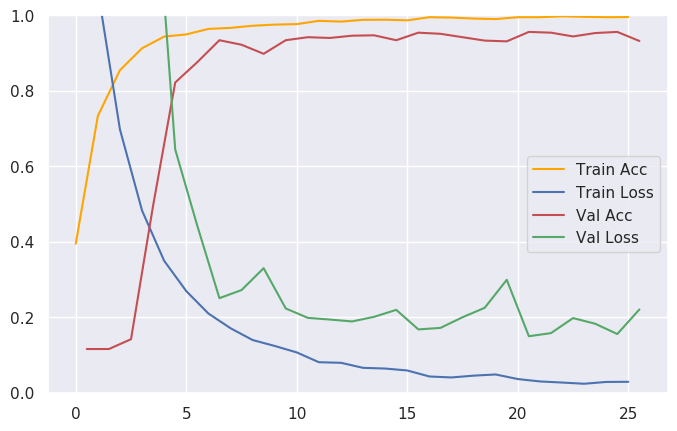

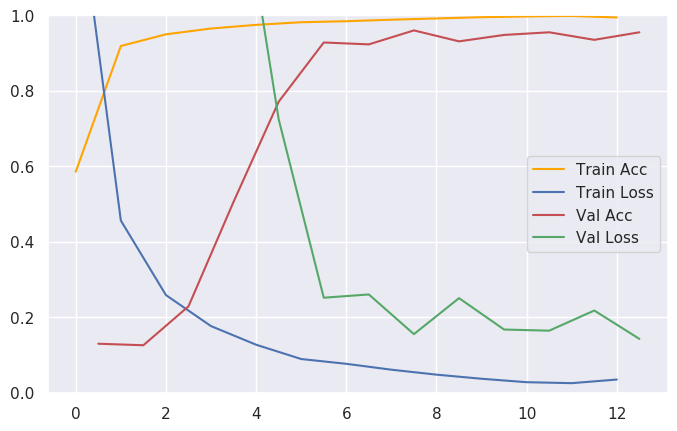

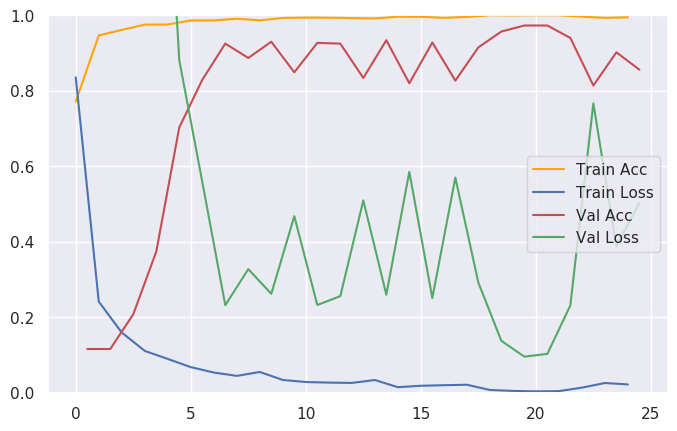

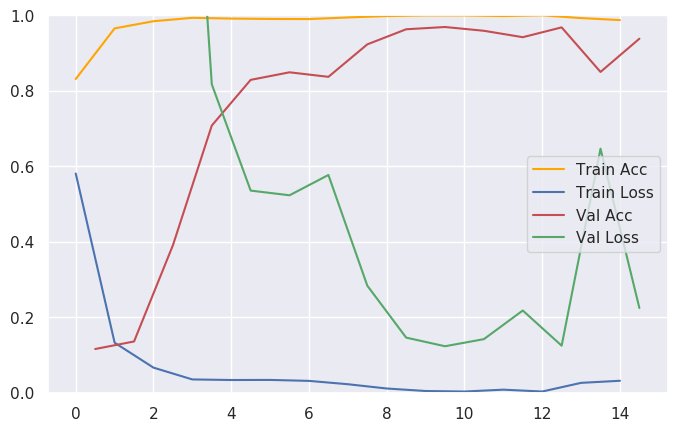

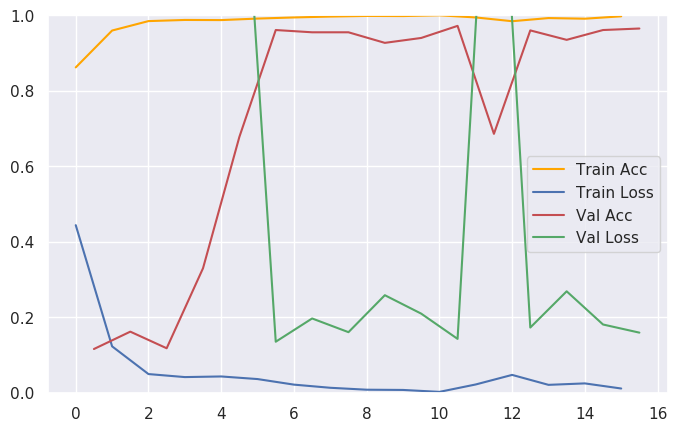

In [32]:
print(acc_result)
for his in history_result:
    
    plot_history(his)